<a href="https://colab.research.google.com/github/Tsunami-Song/DSDNE/blob/main/experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from __future__ import print_function, division
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py 
import plotly.graph_objs as go 
py.init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(15)
edges = pd.read_csv("/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
features = pd.read_csv("/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("/content/drive/MyDrive/AML/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features
features = pd.merge(features,classes,left_on="txId",right_on="txId",how='left')
features['class'] = features['class'].apply(lambda x: '0' if x == "unknown" else x)

In [6]:

data = pd.read_csv(r"/content/drive/MyDrive/SDNE/sdne_feature2_pro_b8.txt")
orig2contiguos = pd.read_csv(r"/content/drive/MyDrive/AML/EvolveGCN-master/elliptic_bitcoin_dataset/elliptic_txs_orig2contiguos.csv")
orig2contiguos.columns=["originalId","txId"]
new_sdne_feature = pd.merge(orig2contiguos,data,on='txId')
new_sdne_feature = new_sdne_feature.drop('txId',axis=1)
sdne_feature_col = ["sdne_feature_"+str(i) for i in range(1,65)]
new_sdne_feature.columns=["txId"]+sdne_feature_col
sdne_feature_names = ["sdne_feature_"+str(i) for i in range(1,65)]


data_pro = pd.read_csv(r"/content/drive/MyDrive/SDNE/sdne_feature2_pro_b8_mm.txt")
orig2contiguos = pd.read_csv(r"/content/drive/MyDrive/AML/EvolveGCN-master/elliptic_bitcoin_dataset/elliptic_txs_orig2contiguos.csv")
orig2contiguos.columns=["originalId","txId"]
new_sdne_feature_pro = pd.merge(orig2contiguos,data_pro,on='txId')
new_sdne_feature_pro = new_sdne_feature_pro.drop('txId',axis=1)
sdne_feature_col = ["sdne_feature_"+str(i) for i in range(1,65)]
new_sdne_feature_pro.columns=["txId"]+sdne_feature_col
sdne_feature_names = ["sdne_feature_"+str(i) for i in range(1,65)]

In [7]:
def draw_roc(sdne_flag):
  import pandas as pd
  data = features[(features['class']=='1') | (features['class']=='2')]
  if(sdne_flag==1):
    data = pd.merge(data,new_sdne_feature,how='inner')
    X = data[sdne_feature_names]
  elif(sdne_flag==2):
    data = pd.merge(data,new_sdne_feature_pro,how='inner')
    X = data[sdne_feature_names]

  y = data['class']
  y = y.apply(lambda x: 0 if x == '2' else 1 )
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,shuffle=True)

  clf = RandomForestClassifier(n_estimators=50,max_depth=100,random_state=None).fit(X_train,y_train)
  preds = clf.predict(X_test)
  prec,rec,f1,num = precision_recall_fscore_support(y_test,preds, average=None)

  print("Precision:%.3f \nRecall:%.3f \nF1 Score:%.3f"%(prec[1],rec[1],f1[1]))
  micro_f1 = f1_score(y_test,preds,average='micro')
  print("Micro-Average F1 Score:",micro_f1)

  pos_probs =  clf.predict_proba(X_test)
  pos_probs = pos_probs[:, 1]

  plt.figure(figsize=(12, 6), dpi=150)
  plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
  fpr, tpr, _ = roc_curve(y_test, pos_probs)

  plt.plot(fpr, tpr, marker='.', label='AF+SDNE')

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.savefig("ROC_AF+SDNE_Random Forest.png")
  return fpr, tpr

Precision:0.832 
Recall:0.406 
F1 Score:0.546
Micro-Average F1 Score: 0.9362920544022906
Precision:0.833 
Recall:0.459 
F1 Score:0.592
Micro-Average F1 Score: 0.9403722261989979


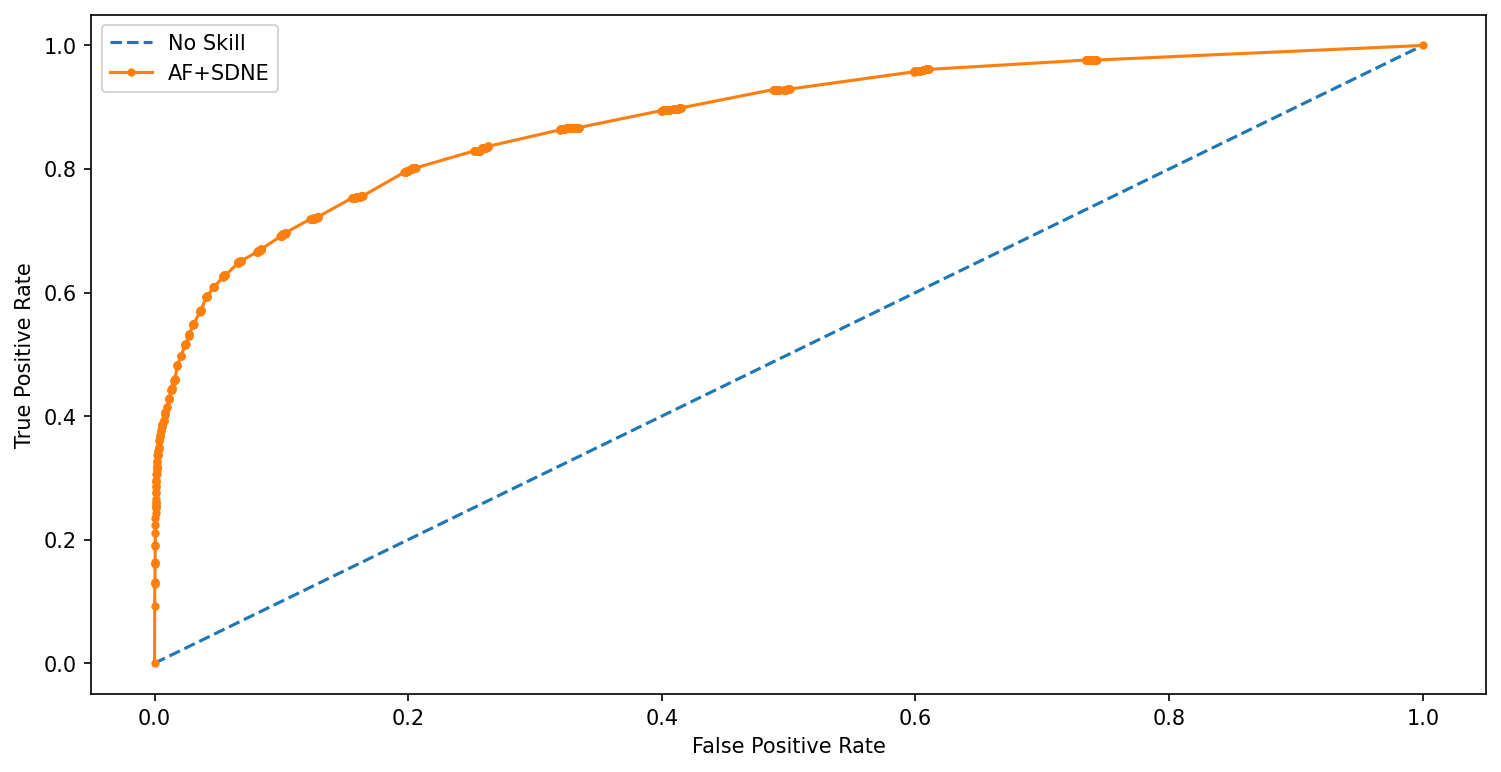

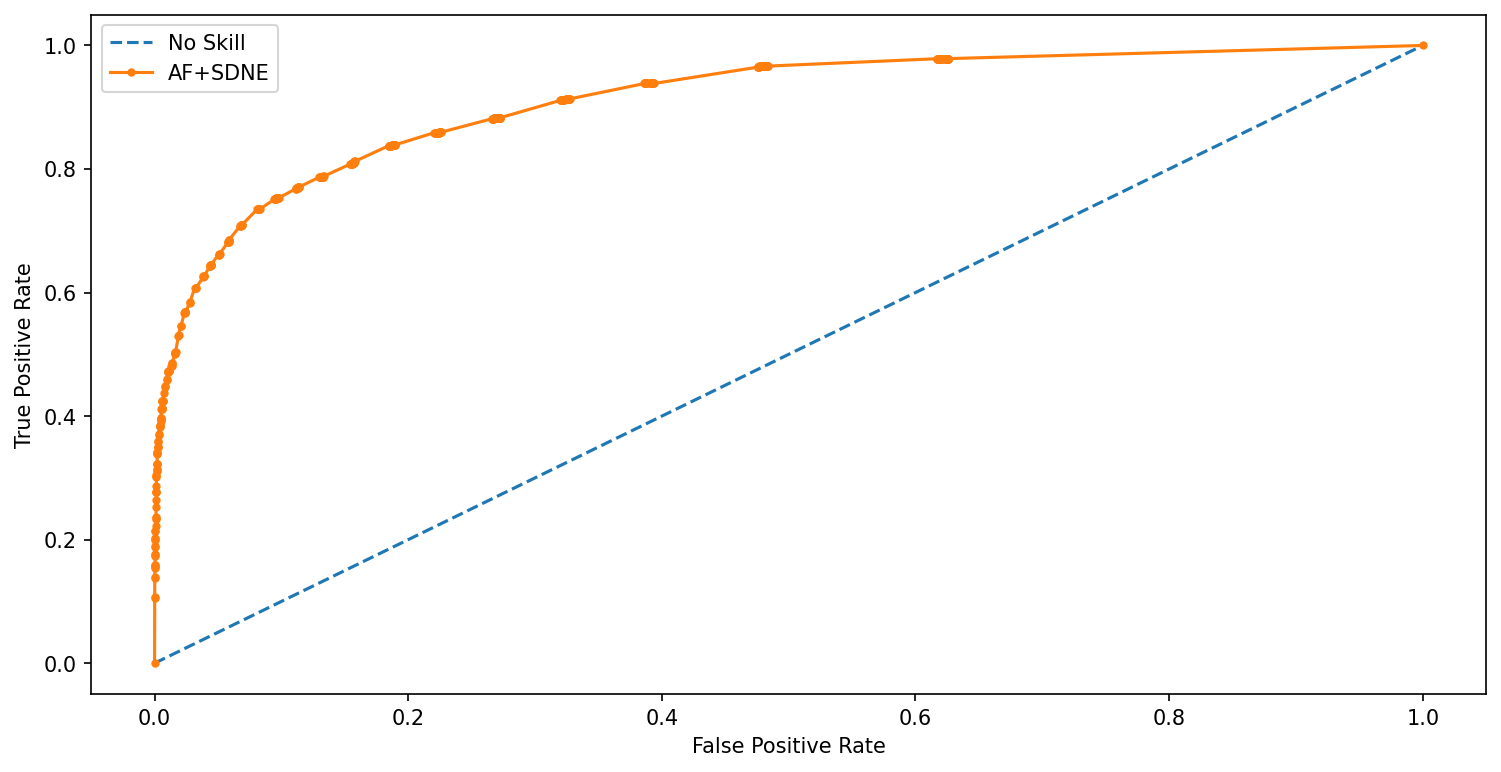

In [8]:
fpr1, tpr1=draw_roc(1)
fpr2, tpr2=draw_roc(2)

In [9]:
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)

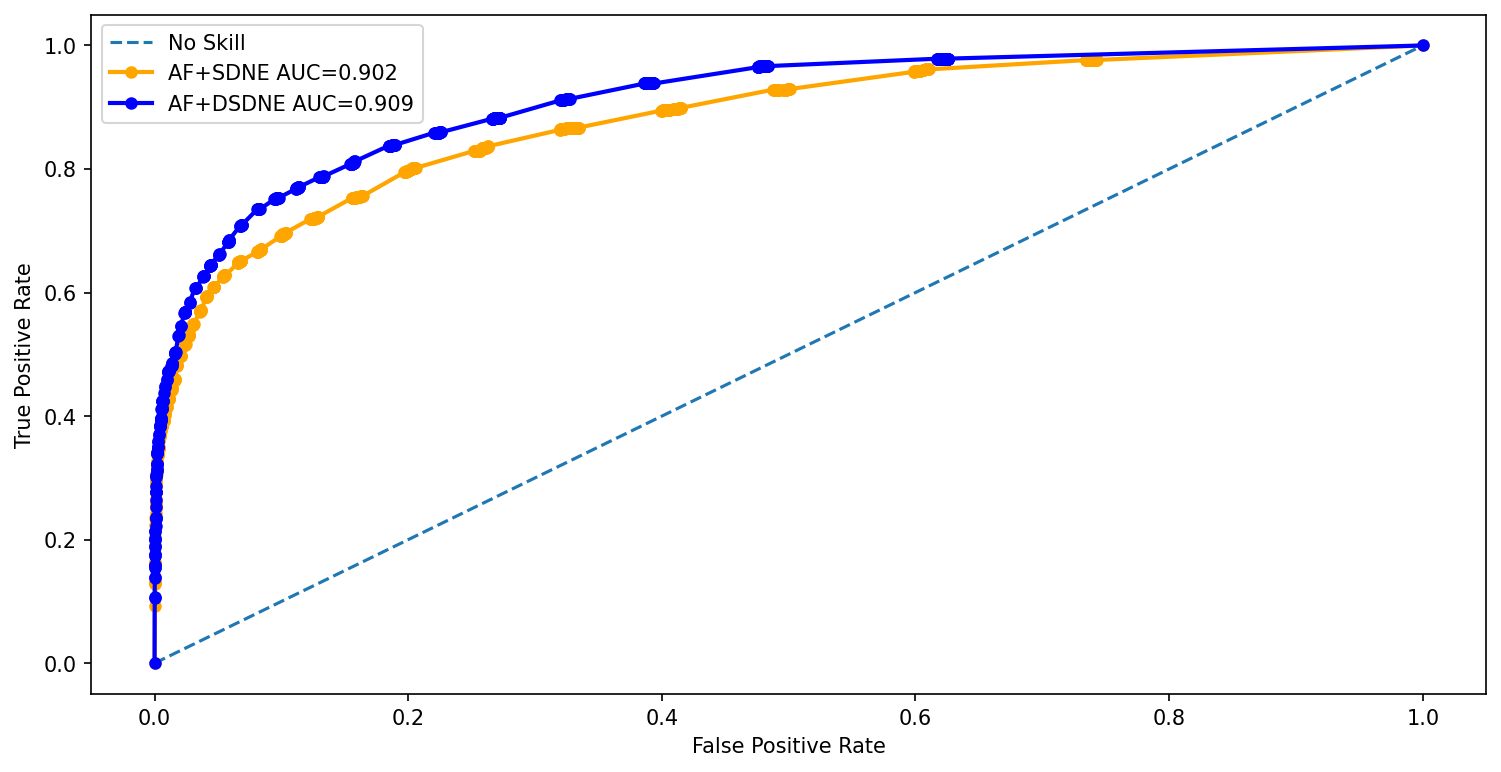

In [10]:
plt.figure(figsize=(12, 6), dpi=150)
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

af_sdne = plt.plot(fpr1, tpr1, "r", marker='.', c='orange', ms=10, linewidth='2', label="AF+SDNE AUC=0.902")
af_dsdne = plt.plot(fpr2, tpr2, "r", marker='.', c='blue', ms=10, linewidth='2', label="AF+DSDNE AUC=0.909")

plt.legend(labels = ["AF illicit F1","AF+SDNE illicit F1","AF+DSDNE illicit F1"])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig("ROC_AF+SDNE_Random Forest.png")